In [115]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg

In [116]:
args = {
    'smooth': False
}

In [117]:
datasets = ['ENERGY', 'SWaT']

def smoothing(dataset):
    try:
        for column in dataset.columns:
            try:
                dataset[column] = sg(dataset[column], window_length=9, polyorder=5)
            except Exception as e:
                print(e)
        return dataset
    except:
        print('Error in smoothing dataframe.')

def normalize(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = min(a), max(a)
    return (a - min_a) / (max_a - min_a), min_a, max_a


def normalize2(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a


def energy_dataset(dataset, ls):
    split_rate = 0.75
    train = dataset.loc[:dataset.shape[0] * split_rate - 1]
    test = dataset.loc[dataset.shape[0] * split_rate:]
    train, test = train.values[0:, 1:].astype(float), test.values[0:, 1:].astype(float)
    train, min_a, max_a = normalize2(train)
    test, _, _ = normalize2(test, min_a, max_a)
    ls = ls.values[:, 0].astype(int)
    labels = np.zeros_like(test)
    for i in range(-5, 5):
        labels[ls + i, :] = 1
    print(train.shape, test.shape, labels.shape)
    return train, test, labels

def swat_dataset(df_train, df_test, labels):
    train, min_a, max_a = normalize(df_train.values)
    test, _, _ = normalize(df_test.values, min_a, max_a)
    print(train.shape, test.shape, labels.shape)
    return train, test, labels


def load_data(dataset):
    folder = os.path.join('data/processed', dataset)
    os.makedirs(folder, exist_ok=True)
    if dataset == 'ENERGY':
        dataset_folder = 'data/raw/ENERGY'
        ls = pd.read_excel(os.path.join(dataset_folder, 'labels.xlsx'))
        dataset = pd.read_csv(os.path.join(dataset_folder, 'energy_consumption_hourly.csv'))
        dataset = dataset[:1000]
        # Check if dataset needed to be smoothed
        if args['smooth']:
            dataset = smoothing(dataset)
            train, test, labels = energy_dataset(dataset, ls)
            return train, test, labels
        #
        else:
            train, test, labels = energy_dataset(dataset, ls)
            return train, test, labels

    elif dataset == 'SWaT':
        dataset_folder = 'data/raw/SWaT'
        file = os.path.join(dataset_folder, 'series.json')
        train = pd.read_json(file, lines=True)[['val']][3000:6000]
        test = pd.read_json(file, lines=True)[['val']][7000:12000]
        labels = pd.read_json(file, lines=True)[['noti']][7000:12000] + 0
        # 
        if args['smooth']:
            train = smoothing(train)
            test = smoothing(test)
            train, test, labels = swat_dataset(train, test, labels)
            return train, test, labels
        #
        else:
            train, test, labels = swat_dataset(train, test, labels)
            return train, test, labels


    else:
        raise Exception(f'Not Implemented. Check one of {datasets}')

In [118]:
train_not_smooth, test_not_smooth, _ = load_data('ENERGY')

(750, 8) (250, 8) (250, 8)


In [119]:
args = {
    'smooth': True
}

In [120]:
train_smooth, test_smooth, _ = load_data('ENERGY')

could not convert string to float: '2006-12-16 17:00:00'
(750, 8) (250, 8) (250, 8)


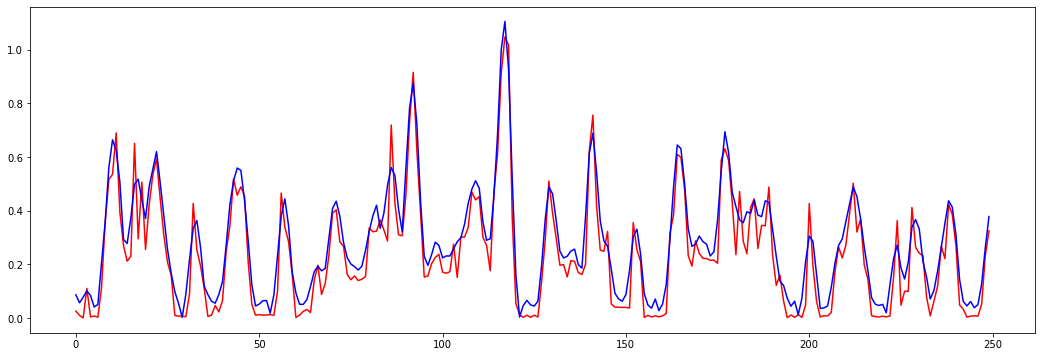

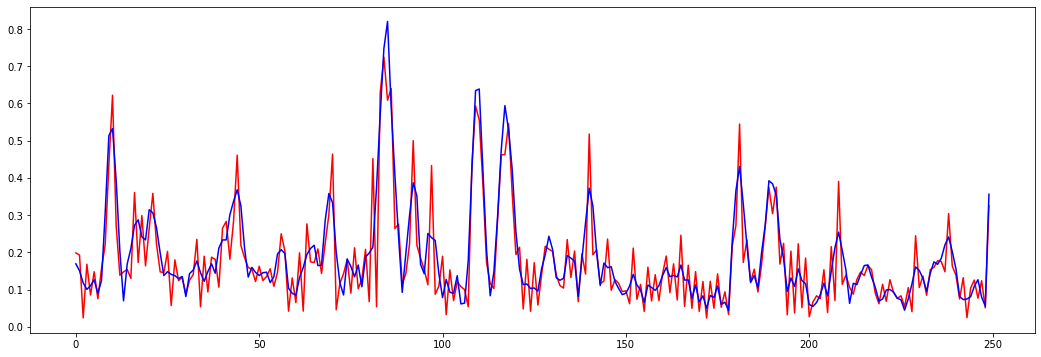

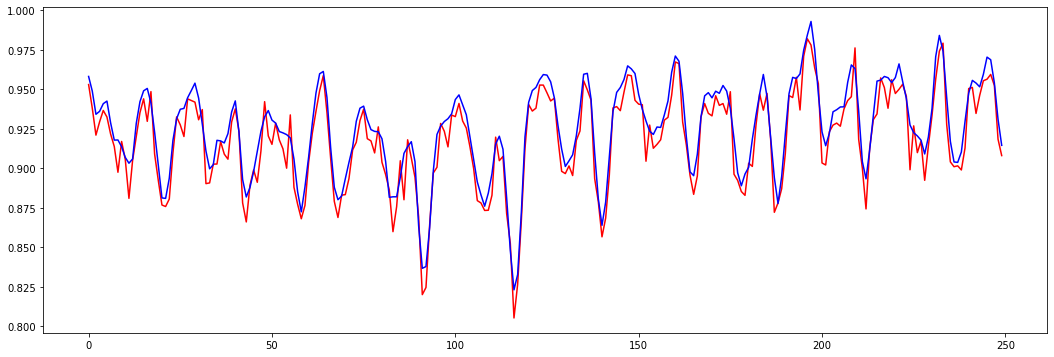

In [121]:
plt.figure(figsize=(18, 6))
plt.plot(test_not_smooth[:, 0], color='r', label='not_smooth')
plt.plot(test_smooth[:, 0], color='b', label='smooth')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(test_not_smooth[:, 1], color='r', label='not_smooth')
plt.plot(test_smooth[:, 1], color='b', label='smooth')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(test_not_smooth[:, 2], color='r', label='not_smooth')
plt.plot(test_smooth[:, 2], color='b', label='smooth')
plt.show()